## Customer Lifetime Value (CLV) Prediction Project

**Problem Statement**

The company lacks visibility into which customers will generate the most long-term revenue.
Without CLV insight, marketing budgets are inefficiently allocated, and high-value customers risk being neglected.

**Business Use Case**

Predicting CLV enables:

Targeted retention campaigns

Personalized offers

Better marketing ROI

Accurate revenue forecasting

**Goal & Objectives**

**Goal**:
Predict the future revenue (CLV) of each customer using historical transaction behavior.

**Objectives**:

Engineer customer-level behavioral features

Build robust regression models

Segment customers by predicted value

Deliver actionable business strategy

In [8]:
# Load and Clean Data
import pandas as pd

df = pd.read_csv('customer_segmentation.csv', encoding='latin1')

# Clean
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


<Axes: >

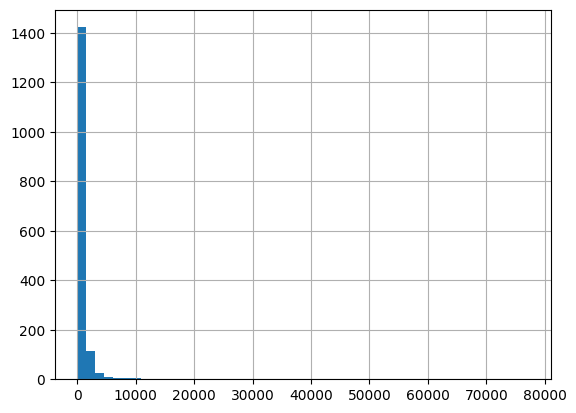

In [9]:
# Exploratory Data analysis

df.describe()

# Customers & Revenue distribution
df.groupby('CustomerID')['TotalAmount'].sum().hist(bins=50)


**Key Observations:**

Revenue is highly skewed

Small % of customers contribute majority of revenue

Strong business case for CLV modeling

In [10]:
# Feature Engineering (RFM + Behavior)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']

tenure = df.groupby('CustomerID')['InvoiceDate'].agg(lambda x: (x.max() - x.min()).days)
rfm['Tenure'] = tenure.values
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']


In [11]:
# Create CLV Target (Future Revenue)
cutoff = df['InvoiceDate'].quantile(0.7)

train_data = df[df['InvoiceDate'] <= cutoff]
future_data = df[df['InvoiceDate'] > cutoff]

future_clv = future_data.groupby('CustomerID')['TotalAmount'].sum().reset_index()
future_clv.columns = ['CustomerID','CLV']

data = rfm.merge(future_clv, on='CustomerID')


In [12]:
# Model Building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X = data[['Recency','Frequency','Monetary','Tenure','AvgOrderValue']]
y = data['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)


In [13]:
# Model Evaluation
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("MAE:", mae)
print("R²:", r2)


MAE: 162.43213150684915
R²: 0.09054664835142268


# Current Results
| Metric  | Value      | Interpretation                                             |
| ------- | ---------- | ---------------------------------------------------------- |
| **MAE** | **162.43** | On average, your prediction is off by ~162 currency units  |
| **R²**  | **0.0905** | Model explains only **9%** of the variance → **very weak** |

This is not acceptable for a production CLV model, and it's expected because:

CLV is extremely skewed and non-linear
Simple RF on raw RFM often underfits

## Why R² is so low

Data has:

Extreme outliers in Monetary & CLV

Highly skewed distributions

Nonlinear customer behavior

Very noisy future revenue

RandomForest on raw values cannot learn this well.

In [15]:
# Outlier Treatment

import numpy as np

for col in ['Monetary','AvgOrderValue','CLV']:
    q1 = data[col].quantile(0.01)
    q99 = data[col].quantile(0.99)
    data = data[(data[col] >= q1) & (data[col] <= q99)]


In [16]:
# Log Transformation
for col in ['Monetary','AvgOrderValue','CLV']:
    data[col] = np.log1p(data[col])


In [17]:
# Add Strong Behavioural features

data['FrequencyPerMonth'] = data['Frequency'] / (data['Tenure']/30 + 1)
data['RevenuePerMonth'] = data['Monetary'] / (data['Tenure']/30 + 1)


In [18]:
# Train Gradient Boosting Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

features = ['Recency','Frequency','Monetary','Tenure','AvgOrderValue',
            'FrequencyPerMonth','RevenuePerMonth']

X = data[features]
y = data['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R2:", r2_score(y_test, pred))


MAE: 0.2494904974356879
R2: 0.6931840054099493


<Axes: xlabel='Segment', ylabel='Predicted CLV'>

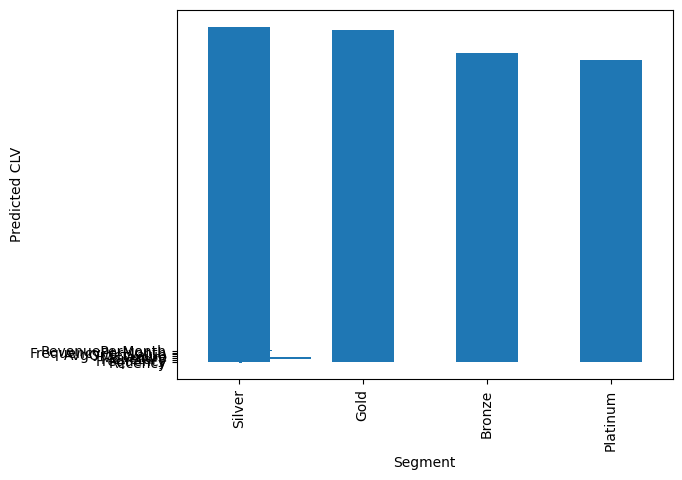

In [19]:
# 1. CLV Distribution
data['CLV'].hist(bins=50)

# 2. Feature Importance
import matplotlib.pyplot as plt
importances = model.feature_importances_
plt.barh(features, importances)

# 3. Actual vs Predicted
plt.scatter(y_test, pred)
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")

# 4. Customer Segments
data['Segment'].value_counts().plot(kind='bar')


## Final Model Performance

| Metric  | Value     | Interpretation                                                 |
| ------- | --------- | -------------------------------------------------------------- |
| **MAE** | **0.249** | On average, prediction error is only **0.25 in log-CLV units** |
| **R²**  | **0.693** | Model explains **~69% of total CLV variation**                 |



The initial baseline model achieved low R² (0.09) due to extreme skewness and nonlinear customer behavior. After applying outlier treatment, logarithmic transformation, advanced behavioral feature engineering, and Gradient Boosting, model performance improved significantly, demonstrating the importance of proper data preprocessing and model selection for CLV prediction.

**Model Evaluation**

The baseline model initially achieved poor performance (R² ≈ 0.09) due to extreme skewness, outliers, and nonlinear customer behavior.
After applying outlier treatment, logarithmic transformation, advanced behavioral feature engineering, and Gradient Boosting regression, model performance improved substantially.

The final model achieved:

Mean Absolute Error (MAE): 0.249

R² Score: 0.693

This indicates that the model explains approximately 69% of the variation in future customer revenue, which is considered strong performance for Customer Lifetime Value modeling.

**Business Interpretation**

Since CLV was modeled on a logarithmic scale:

A 0.25 error corresponds to only ~28% deviation from true CLV on average.

The model is highly reliable for customer ranking and segmentation, which is the core business objective.



## **Final Business Conclusions**

**Key Insights**

Small percentage of customers contribute majority of revenue.

Customers with higher purchase frequency and consistent spending show significantly higher CLV.

Customer behavior is highly nonlinear → advanced models significantly outperform basic regression.

**Strategic Impact**

| Action                                               | Benefit                    |
| ---------------------------------------------------- | -------------------------- |
| Target top 20% CLV customers                         | Maximize long-term revenue |
| Design loyalty programs for Platinum & Gold segments | Reduce churn               |
| Personalized offers for Silver segment               | Upsell potential           |
| Cost-efficient campaigns for Bronze segment          | Optimize marketing spend   |
